# Import Dependencies for GAN training


In [2]:
# Import dependencies, assert the required versions for the used APIs.
import sys
assert sys.version_info >= (3, 7)
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
IS_COLAB = "google.colab" in sys.modules
if IS_COLAB:
    import os
    os.environ["TF_USE_LEGACY_KERAS"] = "1"
    import tf_keras
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load The MNIST dataset

In [3]:
# Define paths
DATA_DIR = "mnist_data"
NPZ_PATH = os.path.join(DATA_DIR, "mnist.npz")

# Load or download MNIST data + cache
if not os.path.exists(NPZ_PATH):
    os.makedirs(DATA_DIR, exist_ok=True)
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    np.savez(NPZ_PATH, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    print("Saved MNIST to disk.")
else:
    with np.load(NPZ_PATH) as data:
        X_train, y_train = data["X_train"], data["y_train"]
        X_test, y_test = data["X_test"], data["y_test"]
    print("Loaded MNIST from cache.")

# Normalize and process
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


11490434/11490434 [==============================] - 1s 0us/step
Saved MNIST to disk.


# Visualize Samples of the Real dataset


Training Data Samples:


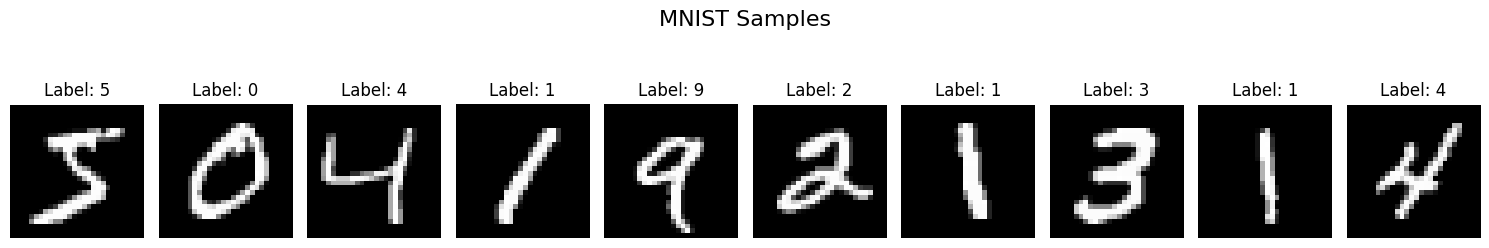

In [ ]:
# Visualization function
def visualize_samples(images, labels, num_samples=10, title="MNIST Samples"):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=16)
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize training data
print("\nTraining Data Samples:")
visualize_samples(X_train, y_train)

In [5]:
# Function used to reduce dataset to 1000 example per digit for training set and 200 example per digit for test set.
def reduce_mnist(X, y, samples_per_class):
    X_reduced, y_reduced = [], []
    for digit in range(10):
        indices = np.where(y == digit)[0]
        sampled_indices = np.random.choice(indices, samples_per_class, replace=False)
        X_reduced.append(X[sampled_indices])
        y_reduced.append(y[sampled_indices])
    return np.concatenate(X_reduced), np.concatenate(y_reduced)

X_train_reduced, y_train_reduced = reduce_mnist(X_train, y_train, samples_per_class=1000)
X_test_reduced, y_test_reduced = reduce_mnist(X_test, y_test, samples_per_class=200)

In [26]:
# Parameters
load_model = True
codings_size = 100
num_classes = 10
batch_size = 32
img_shape = (28, 28, 1)

# Create datasets for GAN training
labels = tf.keras.utils.to_categorical(y_train_reduced, num_classes)  # One-hot encode labels.
label_dataset = tf.data.Dataset.from_tensor_slices(labels).shuffle(1000).batch(batch_size, drop_remainder=True).prefetch(1)
# convert normalized images [0, 1] to [-1, 1] as we use tanh actication function in the generator.
X_train_dcgan = X_train_reduced.reshape(-1, 28, 28, 1) * 2. - 1.
images_dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
images_dataset = images_dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# The GAN Archeticture
The archeticture follows the Alec Radford et al guidelines for training stable deep convolutional GANs (DCGANs) except that the BatchNormalization layers in the discriminator were replaced  with Dropout layers.

**Generator Forward Pass Flow:**
```
Input (Noise + Label) → Concatenate → Dense(7*7*128) + Reshape(7,7,128) → BatchNormalization → Conv2DTranspose(64)
→ BatchNormalization → Conv2DTranspose(1) → Output (Generated Image)
```
**Discriminator Forward Pass Flow:**
```
Image + Label → Conv2D(64) → Dropout(0.4) → Conv2D(128) → Dropout(0.4) → Flatten → Label Embedding (Dense(128))
→ Concatenate (Image Features + Label Embedding) → Dense(1, sigmoid) (Real/Fake Prediction)

```

**GAN Forward Pass Flow:**
```
Noise + Label → Generator → Fake Image  → Discriminator(Fake Image + Label) → Validity Score (Binary Cross-Entropy Loss)

```

# Summary of Dimensions

In [16]:
print(discriminator.summary())
print(generator.summary())

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 6272)                 206592    ['input_5[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  1408      ['input_6[0][0]']             
                                                                                      

In [35]:
# Ensure reproducibility
tf.random.set_seed(42)

# Generator: Use functional API for inputs (due to multiple inputs), Sequential for layers
generator_inputs = [
    tf.keras.layers.Input(shape=(codings_size,)),  # Noise input
    tf.keras.layers.Input(shape=(num_classes,))    # Label input
]
concatenated_input = tf.keras.layers.Concatenate()(generator_inputs)  # Combine noise and label

# Define the generator's main pipeline
generator_seq = tf.keras.models.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128, input_shape=(codings_size + num_classes,)),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh")
])

# Connect the concatenated input to the Sequential model
generator_output = generator_seq(concatenated_input)
generator = tf.keras.Model(generator_inputs, generator_output, name="generator")

# Discriminator: Use functional API for inputs, Sequential for image processing
discriminator_inputs = [
    tf.keras.layers.Input(shape=img_shape),  # Image input
    tf.keras.layers.Input(shape=(num_classes,))  # Label input
]
img_input = discriminator_inputs[0]
label_input = discriminator_inputs[1]

# Define the image processing pipeline as Sequential
discriminator_seq = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2), input_shape=img_shape),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten()
])

# Process the image input
img_features = discriminator_seq(img_input)

# Embed the label and combine with image features
label_embedding = tf.keras.layers.Dense(128)(label_input)  # Embed the label
concatenated_features = tf.keras.layers.Concatenate()([img_features, label_embedding])
discriminator_output = tf.keras.layers.Dense(1, activation="sigmoid")(concatenated_features)
discriminator = tf.keras.Model(discriminator_inputs, discriminator_output, name="discriminator")

# Compile the discriminator
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=["accuracy"]
)

# Set discriminator to non-trainable for the GAN
discriminator.trainable = False

# Build and compile the GAN (use functional API due to multiple inputs)
gan_inputs = [
    tf.keras.layers.Input(shape=(codings_size,)),  # Noise input
    tf.keras.layers.Input(shape=(num_classes,))    # Label input
]
fake_img = generator(gan_inputs)
validity = discriminator([fake_img, gan_inputs[1]])
gan = tf.keras.Model(gan_inputs, validity, name="gan")
gan.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
)

In [20]:
# Function to plot generated
def plot_multiple_images(images, labels=None,n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols,n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="gray")
        if labels is not None:
          plt.title(f"Label: {labels[index]}")
        plt.axis("off")

Epoch 1/50 | Average D loss = 0.3349358150377296 | Average GAN loss = 1.087020276269565
Epoch 2/50 | Average D loss = 0.6549742622062181 | Average GAN loss = 0.9262687504673616
Epoch 3/50 | Average D loss = 0.6503297279660518 | Average GAN loss = 0.8266321063423768
Epoch 4/50 | Average D loss = 0.6403666824484483 | Average GAN loss = 0.8333743533644921
Epoch 5/50 | Average D loss = 0.6213038166364034 | Average GAN loss = 0.8719102425070909
Epoch 6/50 | Average D loss = 0.5989675454031198 | Average GAN loss = 0.9264484592355214
Epoch 7/50 | Average D loss = 0.6037483767439158 | Average GAN loss = 0.9340483748759979
Epoch 8/50 | Average D loss = 0.6269799428872573 | Average GAN loss = 0.8898273293788617
Epoch 9/50 | Average D loss = 0.6379541237002764 | Average GAN loss = 0.8790892555545538
Epoch 10/50 | Average D loss = 0.641551809051098 | Average GAN loss = 0.8579046511306212


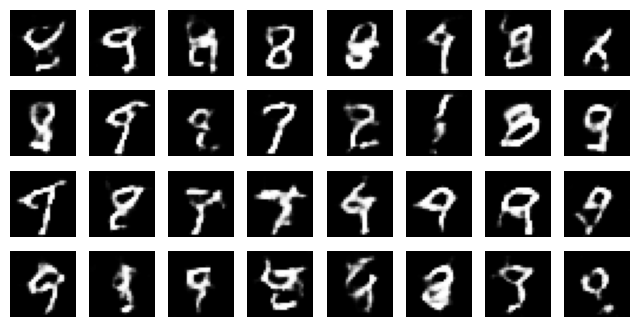

Epoch 11/50 | Average D loss = 0.6419958380552439 | Average GAN loss = 0.8512766728034387
Epoch 12/50 | Average D loss = 0.6432409790846018 | Average GAN loss = 0.8462693800146763
Epoch 13/50 | Average D loss = 0.6459379857167219 | Average GAN loss = 0.8338479281235964
Epoch 14/50 | Average D loss = 0.6445953360734842 | Average GAN loss = 0.8351922368583007
Epoch 15/50 | Average D loss = 0.6452167504108869 | Average GAN loss = 0.8305837876903706
Epoch 16/50 | Average D loss = 0.6438510710230241 | Average GAN loss = 0.8401192354086118
Epoch 17/50 | Average D loss = 0.6431479104436361 | Average GAN loss = 0.8317548861870399
Epoch 18/50 | Average D loss = 0.6399534761141508 | Average GAN loss = 0.8378163583767719
Epoch 19/50 | Average D loss = 0.6447164060977789 | Average GAN loss = 0.83953290222547
Epoch 20/50 | Average D loss = 0.6381269727761929 | Average GAN loss = 0.8421830573143103


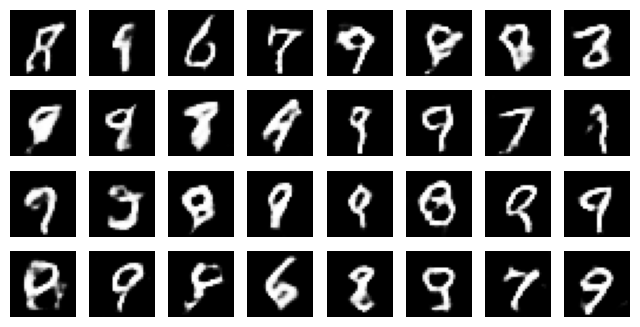

Epoch 21/50 | Average D loss = 0.6376649210086236 | Average GAN loss = 0.8430246762358226
Epoch 22/50 | Average D loss = 0.6387671020168525 | Average GAN loss = 0.8459138482426986
Epoch 23/50 | Average D loss = 0.6387510856565757 | Average GAN loss = 0.855246270314241
Epoch 24/50 | Average D loss = 0.6357589171100886 | Average GAN loss = 0.8485636178117532
Epoch 25/50 | Average D loss = 0.6345835010974835 | Average GAN loss = 0.8478032123201933
Epoch 26/50 | Average D loss = 0.6343130245804787 | Average GAN loss = 0.8673425419972494
Epoch 27/50 | Average D loss = 0.638085503417712 | Average GAN loss = 0.8563311245196905
Epoch 28/50 | Average D loss = 0.6312724162752812 | Average GAN loss = 0.858925444766497
Epoch 29/50 | Average D loss = 0.6321806636376258 | Average GAN loss = 0.8618458014650222
Epoch 30/50 | Average D loss = 0.63469142275743 | Average GAN loss = 0.8664467991926731


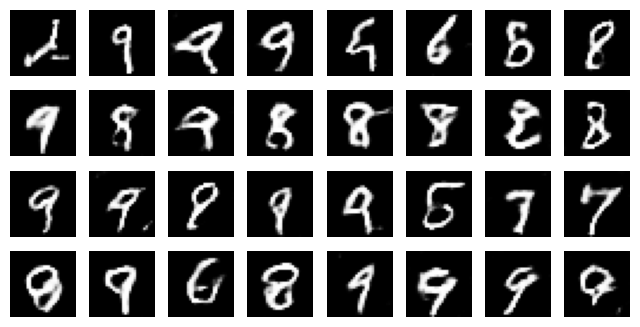

Epoch 31/50 | Average D loss = 0.6336860798108273 | Average GAN loss = 0.865439598950056
Epoch 32/50 | Average D loss = 0.6342813181571472 | Average GAN loss = 0.8728168196020982
Epoch 33/50 | Average D loss = 0.6354007694201592 | Average GAN loss = 0.8594584940717771
Epoch 34/50 | Average D loss = 0.6320348531007767 | Average GAN loss = 0.8643416126187031
Epoch 35/50 | Average D loss = 0.6362451716111257 | Average GAN loss = 0.8659524252781501
Epoch 36/50 | Average D loss = 0.6357635341775723 | Average GAN loss = 0.8610553647845219
Epoch 37/50 | Average D loss = 0.634034320138968 | Average GAN loss = 0.8601708150444887
Epoch 38/50 | Average D loss = 0.6393550074635408 | Average GAN loss = 0.8617711411072657
Epoch 39/50 | Average D loss = 0.6355851023243024 | Average GAN loss = 0.8704667049340713
Epoch 40/50 | Average D loss = 0.6345599652864994 | Average GAN loss = 0.858979450013393


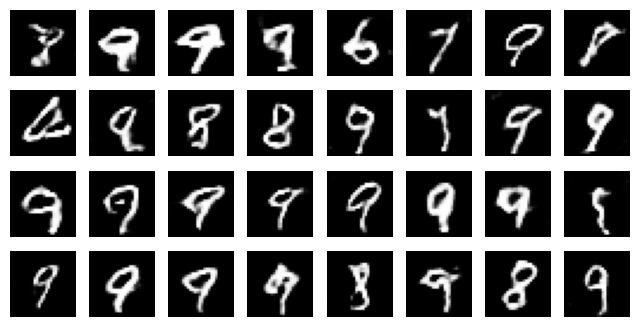

Epoch 41/50 | Average D loss = 0.6347351591938581 | Average GAN loss = 0.8643665115038554
Epoch 42/50 | Average D loss = 0.6334811869340066 | Average GAN loss = 0.8704242912622598
Epoch 43/50 | Average D loss = 0.6348305493593216 | Average GAN loss = 0.8618847584495177
Epoch 44/50 | Average D loss = 0.6344569413325726 | Average GAN loss = 0.8651414173535812
Epoch 45/50 | Average D loss = 0.6342786435897534 | Average GAN loss = 0.8728313910273405
Epoch 46/50 | Average D loss = 0.6314952562634761 | Average GAN loss = 0.8723543458260022
Epoch 47/50 | Average D loss = 0.6337176568997211 | Average GAN loss = 0.8743432968472823
Epoch 48/50 | Average D loss = 0.636410422050036 | Average GAN loss = 0.8788808353054218
Epoch 49/50 | Average D loss = 0.6281529947733268 | Average GAN loss = 0.8701349317263334
Epoch 50/50 | Average D loss = 0.6311829479841086 | Average GAN loss = 0.8736134570760604


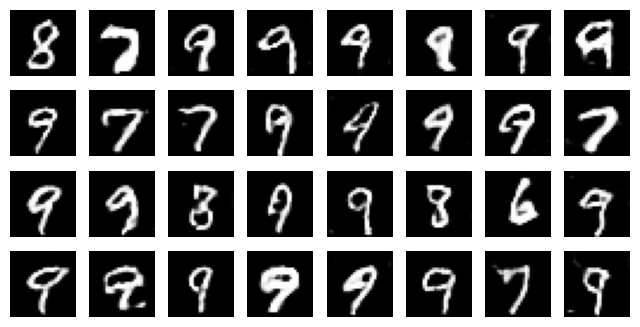

In [ ]:
# cDCGAN training loop
def train_gan(gan, dataset, label_dataset, batch_size, codings_size, n_epochs):
    d_losses, g_losses = [], []
    for epoch in range(n_epochs):
        epoch_d_loss, epoch_g_loss = 0, 0
        for (X_batch, batch_labels) in zip(dataset, label_dataset):
            # Phase 1 - Training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator([noise, batch_labels])

            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)

            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            labels_fake_and_real = tf.concat([batch_labels, batch_labels], axis=0)  # Same labels for fake and real
            d_loss = discriminator.train_on_batch([X_fake_and_real, labels_fake_and_real], y1)

            # Phase 2 - Training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            g_loss = gan.train_on_batch([noise, batch_labels], y2)

            epoch_d_loss += d_loss[0]
            epoch_g_loss += g_loss

        # Average losses
        epoch_d_loss /= len(dataset)
        epoch_g_loss /= len(dataset)
        d_losses.append(epoch_d_loss)
        g_losses.append(epoch_g_loss)
        print(f"Epoch {epoch + 1}/{n_epochs} | Average D loss = {epoch_d_loss} | Average GAN loss = {epoch_g_loss}")
        # Visualize images every 10 epochs
        if (epoch + 1) % 10 == 0:
          plot_multiple_images(generated_images, n_cols=8)
          plt.show()
    return g_losses, d_losses


# Train the GAN
g_losses, d_losses = train_gan(gan, images_dataset, label_dataset, batch_size, codings_size, n_epochs=50)



In [36]:
# Loading pre-trained generator if saved
if load_model:
  # Load the saved generator
  generator = tf.keras.models.load_model("conditional_generator.keras")

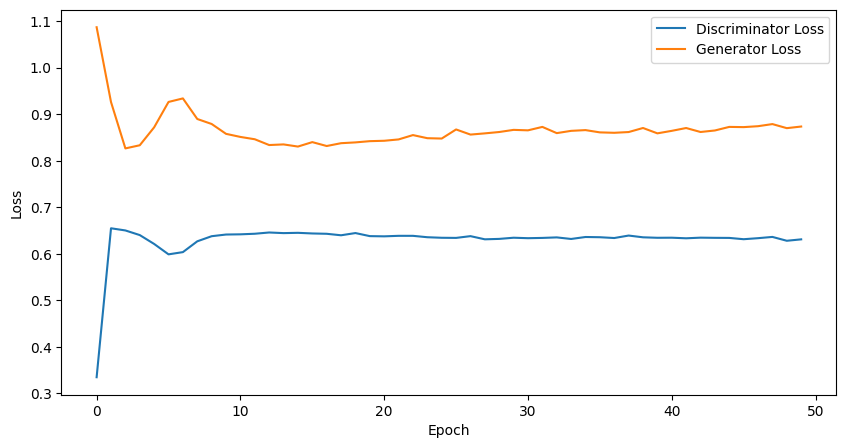

In [ ]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Save the generator after training
generator.save("conditional_generator.keras")

In [29]:
# Function to generate synthetic data with labels
def generate_synthetic_data(num_samples_per_class, codings_size, num_classes):
    synthetic_images = []
    synthetic_labels = []
    for digit in range(num_classes):
        num_samples = num_samples_per_class
        noise = tf.random.normal([num_samples, codings_size])
        label = tf.keras.utils.to_categorical([digit] * num_samples, num_classes)
        generated_imgs = generator.predict([noise, label], verbose=0)
        synthetic_images.append(generated_imgs)
        synthetic_labels.append([digit] * num_samples)
    synthetic_images = np.concatenate(synthetic_images, axis=0)
    synthetic_labels = np.concatenate(synthetic_labels, axis=0)
    return synthetic_images, synthetic_labels

# Generate synthetic data (e.g., 30,000 examples, 3000 per class)
synthetic_images, synthetic_labels = generate_synthetic_data(num_samples_per_class=3000, codings_size=codings_size, num_classes=num_classes)
# synthetic_images: shape (30000, 28, 28, 1), synthetic_labels: shape (30000,)

# Visualize Generated Synthetic Samples

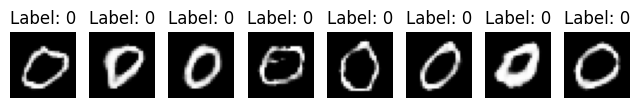

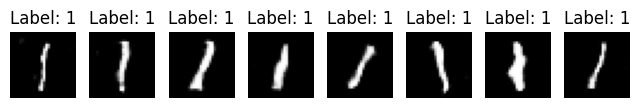

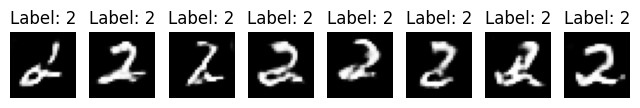

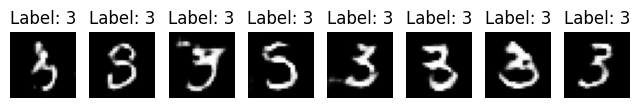

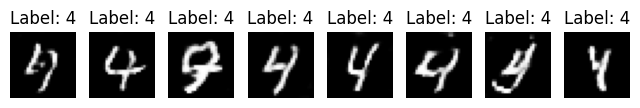

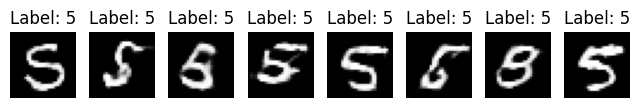

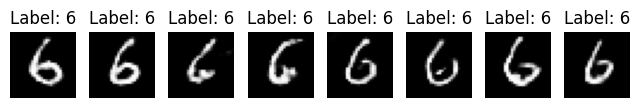

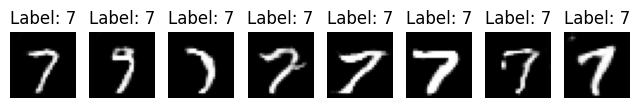

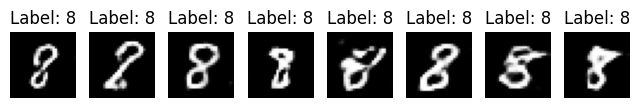

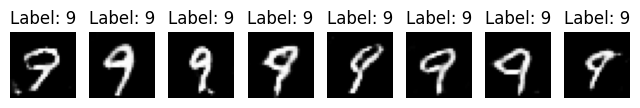

In [38]:
for i in range(0, 30000, 3000):
      plot_multiple_images(
          synthetic_images[i:i+8],
          synthetic_labels[i:i+8],
          n_cols=8
      )

      plt.show()





# Digit Classifier: LeNet5




In [ ]:
# Import dependencies for classifier training
import torch
from torch.utils.data import DataLoader, Dataset

# Import the required classes and functions from LeNet5
from LeNet5_utils import LeNet5, train_loop, check_accuracy
import torchvision.transforms as transforms

In [ ]:
# Convert synthetic data to PyTorch tensors and match data shapes
synthetic_images = torch.tensor(synthetic_images, dtype=torch.float32)
synthetic_images = synthetic_images.permute(0, 3, 1, 2)  # Reshape to (3000, 1, 28, 28) for PyTorch
synthetic_images = (synthetic_images + 1.)/2. # GAN output is in [-1, 1] (tanh activation), but LeNet5 expects data normalized to N(0,1)
X_train = X_train.reshape(-1, 1, 28, 28)
X_test_reduced = X_test_reduced.reshape(-1, 1, 28, 28)

In [ ]:
# Function to combine real and synthetic data
def create_combined_dataset(real_dataset,synth_dataset):
    # Extract real data
    real_images, real_labels = real_dataset
    synth_images, synth_labels = synth_dataset
    # Combine real and synthetic data
    combined_images = np.concatenate([real_images, synth_images])
    combined_labels = np.concatenate([real_labels, synth_labels])

    return (combined_images, combined_labels)


In [ ]:
# Create real datasets with different sizes
real_300 = reduce_mnist(X_train, y_train, samples_per_class=300)   # 300 per digit = 3,000 total
real_700 = reduce_mnist(X_train, y_train, samples_per_class=700)    # 700 per digit = 7,000 total
real_1000 = reduce_mnist(X_train, y_train, samples_per_class=1000)  # 1,000 per digit = 10,000 total

# Create synth datasets with different sizes
synth_0 = reduce_mnist(synthetic_images, synthetic_labels, samples_per_class=0)   # 0 per digit = 0 total
synth_1000 = reduce_mnist(synthetic_images, synthetic_labels, samples_per_class=1000)   # 1,000 per digit = 10,000 total
synth_2000 = reduce_mnist(synthetic_images, synthetic_labels, samples_per_class=2000)    # 2,000 per digit = 20,000 total
synth_3000 = reduce_mnist(synthetic_images, synthetic_labels, samples_per_class=3000)  # 3,000 per digit = 30,000 total

# Test dataset
test_dataset = (X_test_reduced, y_test_reduced)  # 200 per digit = 2,000 total

# Create datasets for all combinations in the table
combinations = {}
real_sizes = [300, 700, 1000]
synth_sizes = [0,1000, 2000, 3000]
real_datasets = [real_300, real_700, real_1000]
synth_datasets = [synth_0, synth_1000, synth_2000, synth_3000]

for real_size, real_dataset in zip(real_sizes, real_datasets):
    for synth_size, synth_dataset in zip(synth_sizes, synth_datasets):
        key = f"{real_size}_real_{synth_size}_synth"
        combinations[key] = create_combined_dataset(real_dataset, synth_dataset)

In [ ]:
# This class is used to prepare dataset for each combination for the LeNet5 training
class NumpyArrayDataset(Dataset):
    def __init__(self, combination, transform=None):
        """
        Args:
            images (np.ndarray): NumPy array of images (N x H x W x C)
            labels (np.ndarray): NumPy array of labels (N,)
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = combination[0]
        self.labels = combination[1]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert numpy array to tensor
        image = torch.from_numpy(image)
        return image, label

In [ ]:
# Ensure reproducibility
tf.random.set_seed(42)

# Dictionary to store results
results = {}

# Test DataLoader
test_dataset = NumpyArrayDataset((X_test_reduced,y_test_reduced))
test_dataloader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False)
# Train and test for each combination
for key, combination in combinations.items():
      # Create dataset
      train_dataset = NumpyArrayDataset(combination)
      train_dataloader = DataLoader(train_dataset,
                        batch_size=batch_size,
                        shuffle=True)

      print(f"\nTraining with {key}")
      # Initialize a new model for each experiment.
      model = LeNet5()
      # Train the model.
      train_loop(model, train_dataloader,len(train_dataset) ,num_epochs=8)

      # Evaluate on test set and training set.
      test_accuracy = check_accuracy(model, test_dataloader, len(test_dataset))
      train_accuracy = check_accuracy(model, train_dataloader, len(train_dataset))

      # Store results
      results[key] = {"train_accuracy": train_accuracy.item(), "test_accuracy": test_accuracy.item()}
      print(f"Train Accuracy: {train_accuracy:.1f}% | Test Accuracy: {test_accuracy:.1f}%")




Training with 300_real_0_synth
Epoch [1/8], Training Accuracy: 71.9%
Epoch [2/8], Training Accuracy: 85.3%
Epoch [3/8], Training Accuracy: 86.0%
Epoch [4/8], Training Accuracy: 90.6%
Epoch [5/8], Training Accuracy: 92.3%
Epoch [6/8], Training Accuracy: 93.4%
Epoch [7/8], Training Accuracy: 92.6%
Epoch [8/8], Training Accuracy: 94.9%
Train Accuracy: 94.9% | Test Accuracy: 93.4%

Training with 300_real_1000_synth
Epoch [1/8], Training Accuracy: 93.0%
Epoch [2/8], Training Accuracy: 95.6%
Epoch [3/8], Training Accuracy: 97.0%
Epoch [4/8], Training Accuracy: 97.5%
Epoch [5/8], Training Accuracy: 98.2%
Epoch [6/8], Training Accuracy: 98.3%
Epoch [7/8], Training Accuracy: 98.5%
Epoch [8/8], Training Accuracy: 98.4%
Train Accuracy: 98.4% | Test Accuracy: 95.1%

Training with 300_real_2000_synth
Epoch [1/8], Training Accuracy: 95.6%
Epoch [2/8], Training Accuracy: 97.2%
Epoch [3/8], Training Accuracy: 97.9%
Epoch [4/8], Training Accuracy: 98.4%
Epoch [5/8], Training Accuracy: 98.6%
Epoch [6/8

In [ ]:
# Print results in a table-like format
print("\nResults Table:")
print("| Generated Examples | 300 Real | 700 Real | 1,000 Real |")
print("|--------------------|----------|----------|------------|")
for synth_size in synth_sizes:
    row = f"| {synth_size} |"
    for real_size in real_sizes:
        key = f"{real_size}_real_{synth_size}_synth"
        test_acc = results[key]["test_accuracy"]
        train_acc = results[key]["train_accuracy"]
        row += f" train acc: {train_acc:.1f}%, test acc: {test_acc:.1f}% |"
    print(row)


Results Table:
| Generated Examples | 300 Real | 700 Real | 1,000 Real |
|--------------------|----------|----------|------------|
| 0 | train acc: 94.9%, test acc: 93.4% | train acc: 96.7%, test acc: 96.1% | train acc: 97.6%, test acc: 97.4% |
| 1000 | train acc: 98.4%, test acc: 95.1% | train acc: 98.1%, test acc: 96.4% | train acc: 98.5%, test acc: 97.7% |
| 2000 | train acc: 99.0%, test acc: 94.7% | train acc: 98.6%, test acc: 96.1% | train acc: 98.6%, test acc: 97.1% |
| 3000 | train acc: 99.4%, test acc: 95.8% | train acc: 99.1%, test acc: 96.4% | train acc: 98.9%, test acc: 96.5% |


Results Table:

| Generated Examples | 300 Real | 700 Real | 1,000 Real |
|--------------------|----------|----------|------------|
| 0 | train acc: 94.9%, test acc: 93.4% | train acc: 96.7%, test acc: 96.1% | train acc: 97.6%, test acc: 97.4% |
| 1000 | train acc: 98.4%, test acc: 95.1% | train acc: 98.1%, test acc: 96.4% | train acc: 98.5%, test acc: 97.7% |
| 2000 | train acc: 99.0%, test acc: 94.7% | train acc: 98.6%, test acc: 96.1% | train acc: 98.6%, test acc: 97.1% |
| 3000 | train acc: 99.4%, test acc: 95.8% | train acc: 99.1%, test acc: 96.4% | train acc: 98.9%, test acc: 96.5% |

# Combination of Augmented and Synthetic data

In [ ]:
# Install p7zip
#!apt-get install p7zip-full

# Extract the file
!7z x augmented_images_28x28_per_class.7z

In [ ]:
# This class is used to prepare the augmented images to be able to combine it with real and synthitec data
class AugmentedImageDataset:
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the images.
        """
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Resize((28, 28)),  # Resize to 28x28
            transforms.Grayscale(),       # Convert to grayscale (1 channel)
            transforms.ToTensor(),        # Convert to tensor
            transforms.Lambda(lambda x: x.numpy())  # Convert to numpy array
        ])

        self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.png')])

        # Extract labels from filenames
        self.labels = []
        for filename in self.image_files:
            label_part = filename.split('class')[-1]
            label = int(label_part.split('_')[0])
            self.labels.append(label)

        # Convert labels to numpy array
        self.labels = np.array(self.labels)

        # Preload all images
        self.images = np.stack([self.transform(Image.open(os.path.join(root_dir, f)))
                              for f in self.image_files])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    # Enable tuple unpacking like (images, labels) = dataset
    def __iter__(self):
        return iter((self.images, self.labels))


Augmented_dir = "/content/augmented_images_28x28_per_class"

Augmented_dataset = AugmentedImageDataset(Augmented_dir)
Augmented_images, Augmented_labels = Augmented_dataset

In [ ]:
real_300 = reduce_mnist(X_train, y_train, samples_per_class=300)   # 300 per digit = 3000 total

synth_1000 = reduce_mnist(synthetic_images, synthetic_labels, samples_per_class=1000)   # 1000 per digit = 10000 total
synth_2000 = reduce_mnist(synthetic_images, synthetic_labels, samples_per_class=2000)

aug_500 = reduce_mnist(Augmented_images, Augmented_labels, samples_per_class=500)


In [ ]:
synth_sizes = [1000, 2000]
aug_sizes = [500, 1000]

synth_datasets = [synth_1000, synth_2000]
aug_datasets = [aug_500, Augmented_dataset]
combinations = {}
for aug_size, aug_dataset in zip(aug_sizes, aug_datasets):
    for synth_size, synth_dataset in zip(synth_sizes, synth_datasets):
        key = f"{aug_size}_augmented_{synth_size}_synth"
        combination_Real_Aug = create_combined_dataset(real_300, aug_dataset)
        combinations[key] = create_combined_dataset(combination_Real_Aug, synth_dataset)

In [ ]:
# Ensure reproducibility
tf.random.set_seed(42)

# Test DataLoader
test_dataset = NumpyArrayDataset((X_test_reduced,y_test_reduced))
test_dataloader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False)
results = {}

# Train and test for each combination
for key, combination in combinations.items():
      # Create dataset
      train_dataset = NumpyArrayDataset(combination)
      train_dataloader = DataLoader(train_dataset,
                        batch_size=batch_size,
                        shuffle=True)

      print(f"\nTraining with {key}")
      # Initialize a new model for each experiment
      model = LeNet5()
      # Train the model
      train_loop(model, train_dataloader,len(train_dataset) ,num_epochs=8)

      # Evaluate on test set
      test_accuracy = check_accuracy(model, test_dataloader, len(test_dataset))
      train_accuracy = check_accuracy(model, train_dataloader, len(train_dataset))

      # Store results
      results[key] = {"train_accuracy": train_accuracy.item(), "test_accuracy": test_accuracy.item()}
      print(f"Train Accuracy: {train_accuracy:.1f}% | Test Accuracy: {test_accuracy:.1f}%")




Training with 500_augmented_1000_synth
Epoch [1/8], Training Accuracy: 89.9%
Epoch [2/8], Training Accuracy: 93.1%
Epoch [3/8], Training Accuracy: 94.4%
Epoch [4/8], Training Accuracy: 95.2%
Epoch [5/8], Training Accuracy: 95.8%
Epoch [6/8], Training Accuracy: 96.2%
Epoch [7/8], Training Accuracy: 96.0%
Epoch [8/8], Training Accuracy: 96.9%
Train Accuracy: 96.9% | Test Accuracy: 96.6%

Training with 500_augmented_2000_synth
Epoch [1/8], Training Accuracy: 93.1%
Epoch [2/8], Training Accuracy: 95.0%
Epoch [3/8], Training Accuracy: 96.0%
Epoch [4/8], Training Accuracy: 96.6%
Epoch [5/8], Training Accuracy: 97.1%
Epoch [6/8], Training Accuracy: 97.3%
Epoch [7/8], Training Accuracy: 97.4%
Epoch [8/8], Training Accuracy: 97.4%
Train Accuracy: 97.4% | Test Accuracy: 96.9%

Training with 1000_augmented_1000_synth
Epoch [1/8], Training Accuracy: 88.8%
Epoch [2/8], Training Accuracy: 93.2%
Epoch [3/8], Training Accuracy: 94.2%
Epoch [4/8], Training Accuracy: 95.4%
Epoch [5/8], Training Accurac

In [ ]:
# Print results in a table-like format
print("\nResults Table:")
print("| Combination | 500 augmented | 1000 augmented |")
print("|-------------|---------------|----------------|")
for synth_size in synth_sizes:
    row = f"| {synth_size} synth |"
    for aug_size in aug_sizes:
        key = f"{aug_size}_augmented_{synth_size}_synth"
        test_acc = results[key]["test_accuracy"]
        train_acc = results[key]["train_accuracy"]
        row += f" train acc: {train_acc:.1f}%, test acc: {test_acc:.1f}% |"
    print(row)


Results Table:
| Combination | 500 augmented | 1000 augmented |
|-------------|---------------|----------------|
| 1000 synth | train acc: 96.9%, test acc: 96.6% | train acc: 96.6%, test acc: 97.3% |
| 2000 synth | train acc: 97.4%, test acc: 96.9% | train acc: 97.4%, test acc: 97.3% |


Results Table:

| Combination | 500 augmented | 1000 augmented |
|-------------|---------------|----------------|
| 1000 synth | train acc: 96.9%, test acc: 96.6% | train acc: 96.6%, test acc: 97.3% |
| 2000 synth | train acc: 97.4%, test acc: 96.9% | train acc: 97.4%, test acc: 97.3% |
